In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import distributions as dist
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms as tr
from torchvision.models import vgg11_bn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from pprint import pprint
from inpainting.custom_layers import Reshape
from inpainting.losses import nll_masked_batch_loss, nll_masked_batch_loss_components
from inpainting.inpainters.mnist import MNISTLinearInpainter, MNISTConvolutionalInpainter
from pathlib import Path
import pickle
from torch import nn


In [22]:
from inpainting.datasets.mnist import train_val_datasets
from inpainting.visualizations.digits import digit_with_mask as vis_digit_mask
from inpainting.training import train_inpainter
from inpainting.utils import classifier_experiment, inpainted, predictions_for_entire_loader
import inpainting.visualizations.samples as vis
from inpainting.datasets import mask_coding as mc
from inpainting.datasets.utils import RandomRectangleMaskConfig


In [5]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = "white"

In [6]:
!ps aux | grep mprzewie

mprzewi+  2501  0.1  2.3 18461184 3094096 ?    Ssl  01:56   1:10 /home/mprzewiezlikowski/anaconda3/envs/uj/bin/python -m ipykernel_launcher -f /home/mprzewiezlikowski/.local/share/jupyter/runtime/kernel-49c55caa-3eec-47f3-9d7d-8c8d890e1eb9.json
root      6180  0.0  0.0  91312  6936 ?        Ss   20:07   0:00 sshd: mprzewiezlikowski [priv]
mprzewi+  6226  0.0  0.0  91312  3092 ?        S    20:07   0:00 sshd: mprzewiezlikowski@pts/95
mprzewi+  6843  0.0  0.0   4504   696 pts/100  Ss+  20:32   0:00 /bin/sh -c ps aux | grep mprzewie
mprzewi+  6845  0.0  0.0  12916   964 pts/100  S+   20:32   0:00 grep mprzewie
mprzewi+ 12802 55.3  2.0 18158908 2734176 ?    Ssl  02:03 613:31 /home/mprzewiezlikowski/anaconda3/envs/uj/bin/python -m ipykernel_launcher -f /home/mprzewiezlikowski/.local/share/jupyter/runtime/kernel-46ca447f-2f64-41bd-83ef-4e388ea6e27d.json
mprzewi+ 29046  0.0  0.0 901552 68344 pts/76   Rl+  01:15   0:55 /home/mprzewiezlikowski/anaconda3/envs/uj/bin/python /home/mprzewiezlikowsk

In [7]:
!echo $CUDA_VISIBLE_DEVICES
!nvidia-smi

1
Sun Mar  8 20:32:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 29%   28C    P8     7W / 250W |   1550MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   26C    P8    11W / 250W |      0MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2 

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

In [9]:
experiment_path = Path("../results/mnist/misgan_like/14x14")
experiment_path.mkdir(exist_ok=True, parents=True)

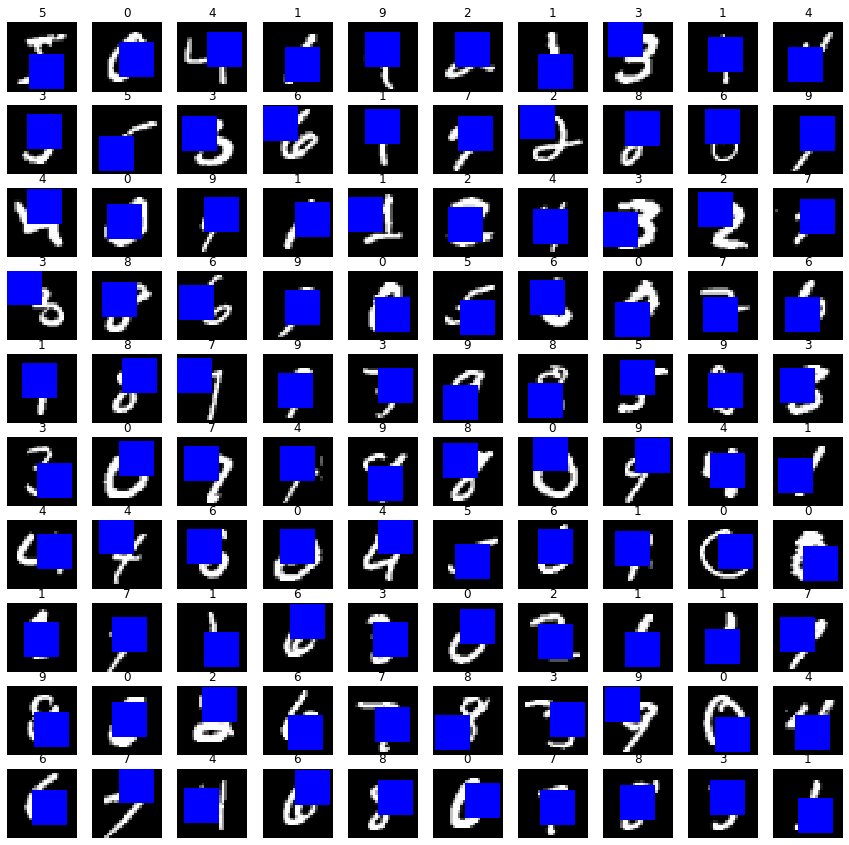

In [12]:
ds_train, ds_val = train_val_datasets(
    Path.home() / "uj/data/",
    mask_configs=[
#         RandomRectangleMaskConfig(mc.UNKNOWN_LOSS, 28,28, 0,0),

        RandomRectangleMaskConfig(mc.UNKNOWN_LOSS, 14, 14, 0,0),
#         RandomRectangleMaskConfig(mc.UNKNOWN_NO_LOSS, 10,10, 0,0)
    ],
    ds_type=MNIST
)

fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(100):
    (x,j), y = ds_train[i]
    ax = axes[i // 10, i%10]
    ax.set_title(f"{y}")
    vis_digit_mask(x, j,ax)
train_fig = plt.gcf()
train_fig.savefig(experiment_path / "train.png")
plt.show()

In [13]:
batch_size=96
dl_train = DataLoader(ds_train, batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size, shuffle=True)

In [14]:
log_noms = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["log_noms"]

x_minus_means = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["x_minus_means"]

x_minus_means_2 = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["x_minus_means_2"]

log_dets = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["log_dets"]

log_2_pi = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["log_2_pi"]

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
# device = torch.device("cpu")
history = []
# inpainter = MNISTLinearInpainter(n_mixes=1, hidden_size=2048)
inpainter = MNISTConvolutionalInpainter(n_mixes=1, a_width=4, a_amplitude=1)

# inpainter.extractor = deep_extractor

opt = optim.Adam(inpainter.parameters(), lr=4e-5, weight_decay=0)
n_epochs = 0
history = train_inpainter(
    inpainter, 
    dl_train, 
    dl_val, 
    opt, 
    loss_fn =nll_masked_batch_loss, 
    n_epochs=n_epochs,
    losses_to_log=dict(
        log_noms=log_dets,
        x_minus_means_2=x_minus_means_2,
        x_minus_means=x_minus_means,
        log_dets=log_dets,
        log_2_pi=log_2_pi,
        nll=nll_masked_batch_loss,
    ),
    device=device,
    history_start=history,
#     tqdm_loader=True
)

0it [00:00, ?it/s]


In [16]:
# history = history_tmp

In [17]:
history[0]["losses"]

IndexError: list index out of range

In [16]:

with (experiment_path / "history_last_epoch.pkl").open("wb") as f:
    history_tmp = history
    pickle.dump(history[-1], f)

In [39]:
with (experiment_path / "inpainter.schema").open("w") as f:
    print(inpainter, file=f)
with (experiment_path / "opt.schema").open("w") as f:
    print(opt, file=f)

torch.save(inpainter.state_dict(), experiment_path / "inpainter.state")

In [40]:
chckp = torch.load(experiment_path / "inpainter.state")
chckp
inpainter.load_state_dict(chckp)

<All keys matched successfully>

In [18]:
len(history)

50

In [19]:
history[-1]["losses"]["objective"]

{'train': -194.0693, 'val': -189.46155}

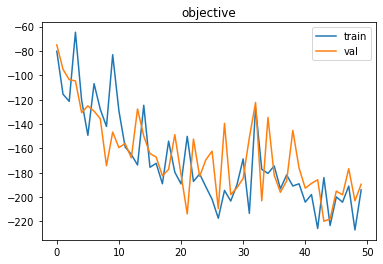

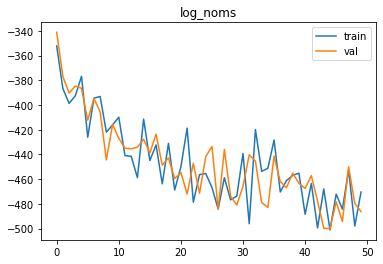

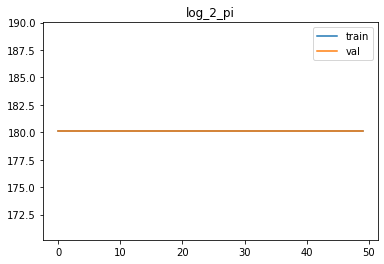

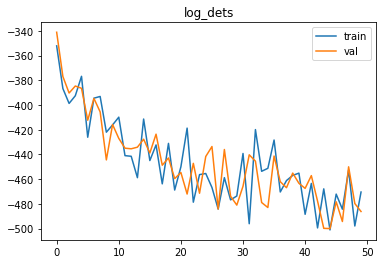

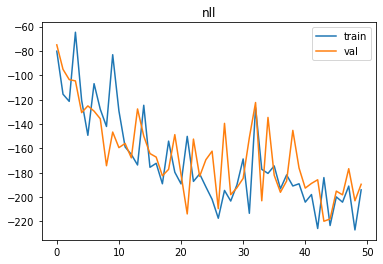

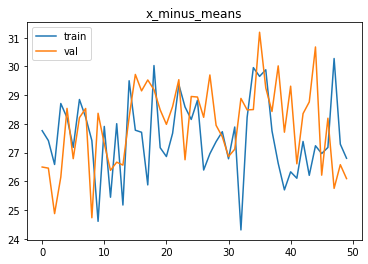

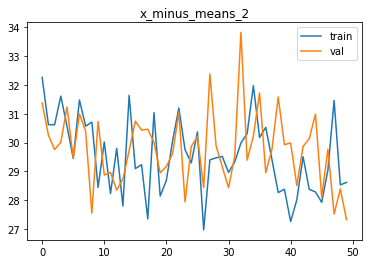

In [20]:
for loss_name in set(history[0]["losses"].keys()):
    for fold in ["train", "val"]:
        
        plt.plot(
            list(range(len(history))),
            [h["losses"][loss_name][fold] for h in history],
            label=fold
        )
    plt.title(loss_name)
    plt.legend()
    fig = plt.gcf()
    fig.savefig(experiment_path / f"history.{loss_name}.png")
    plt.show()

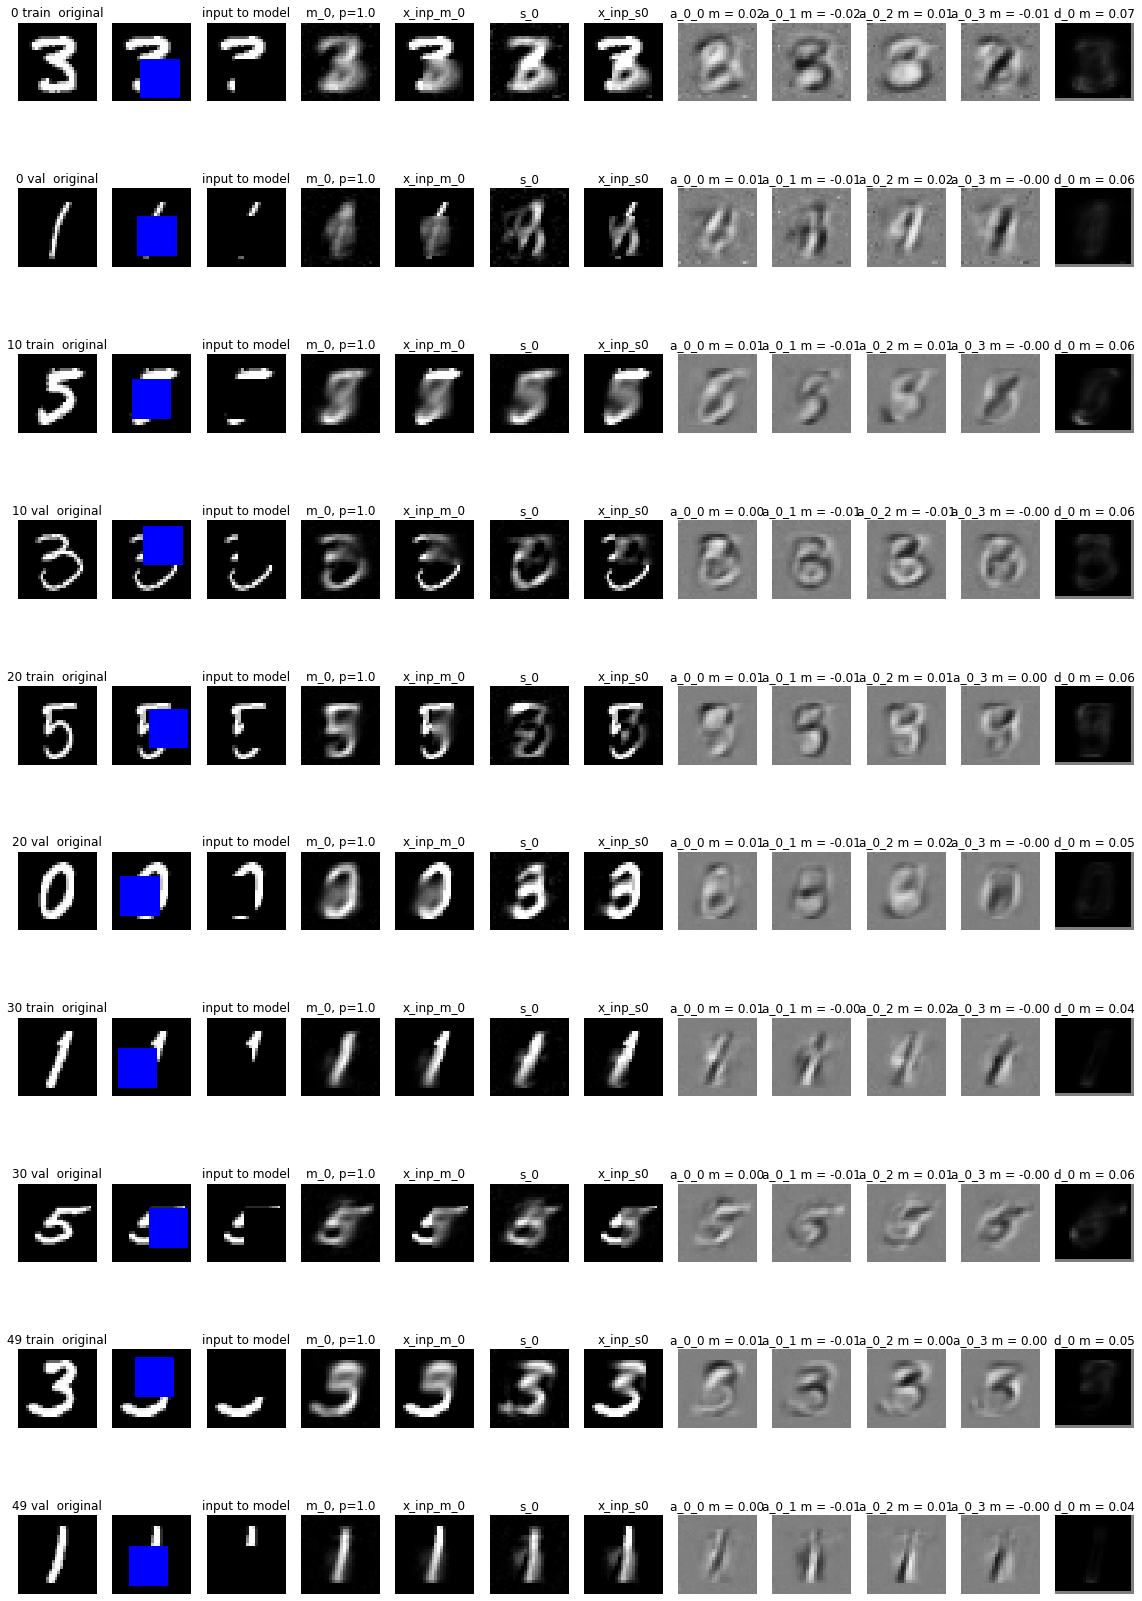

In [21]:
skip = 10

row_length = vis.row_length(*list(zip(*history[0]["sample_results"]["train"]))[0])
fig, axes = plt.subplots(
    int(np.ceil(len(history) / skip)* 2), 
    row_length,
    figsize=(20, 30)
)


for e, h in enumerate(history):
    if e % skip !=0 and e != (len(history) -1):
        continue
    
    for ax_no, fold in [(0,"train"), (1,"val")]:
        x, j, p, m, a, d, y = [t[0] for t in  h["sample_results"][fold]]
        row_no = (e // skip)*2 + ax_no

        vis.visualize_sample(
            x, j, p, m, a, d, y, 
            ax_row=axes[row_no], 
            title_prefixes={
                0: f"{e} {fold} ",
#                 1: f"y_m = {y_masked_pred}"
            },
            drawing_fn=vis_digit_mask
        )

epochs_fig = plt.gcf()
epochs_fig.savefig(experiment_path / "epochs_renders.png")

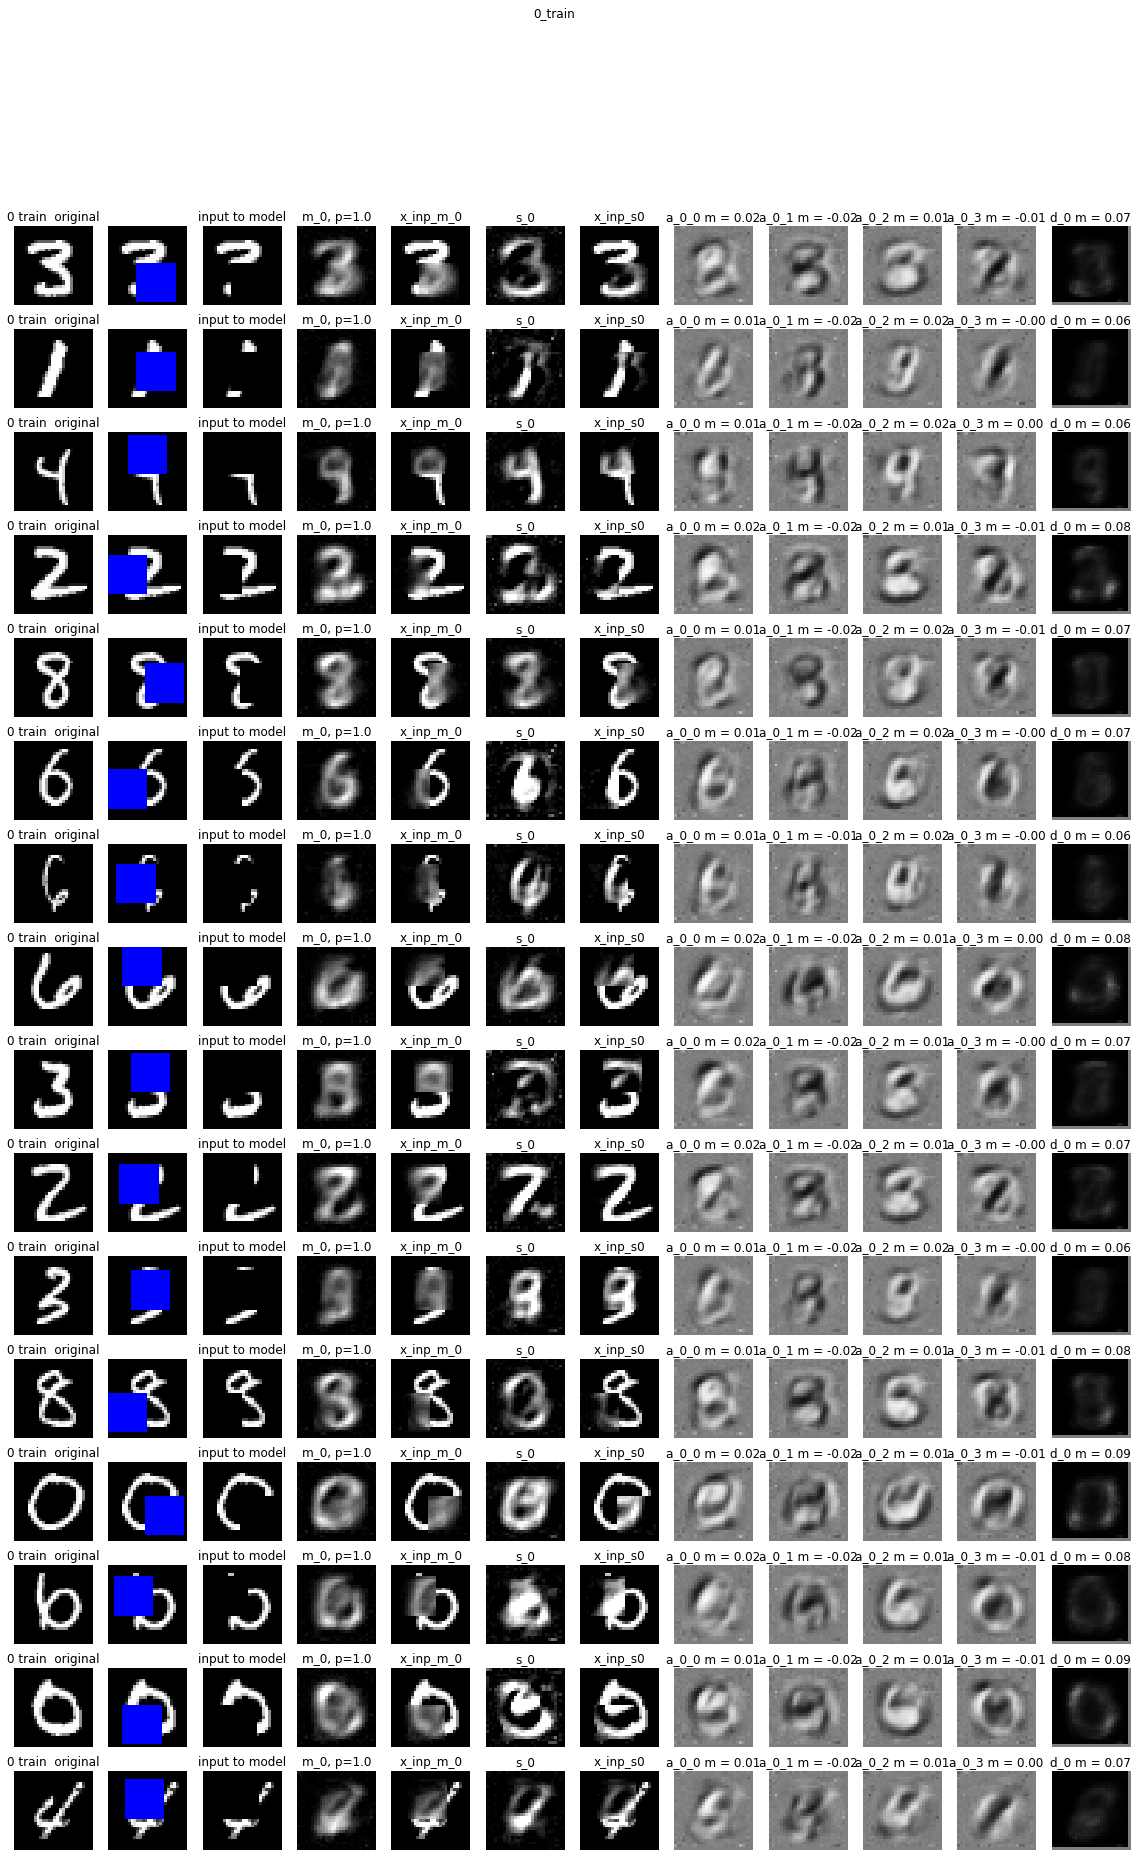

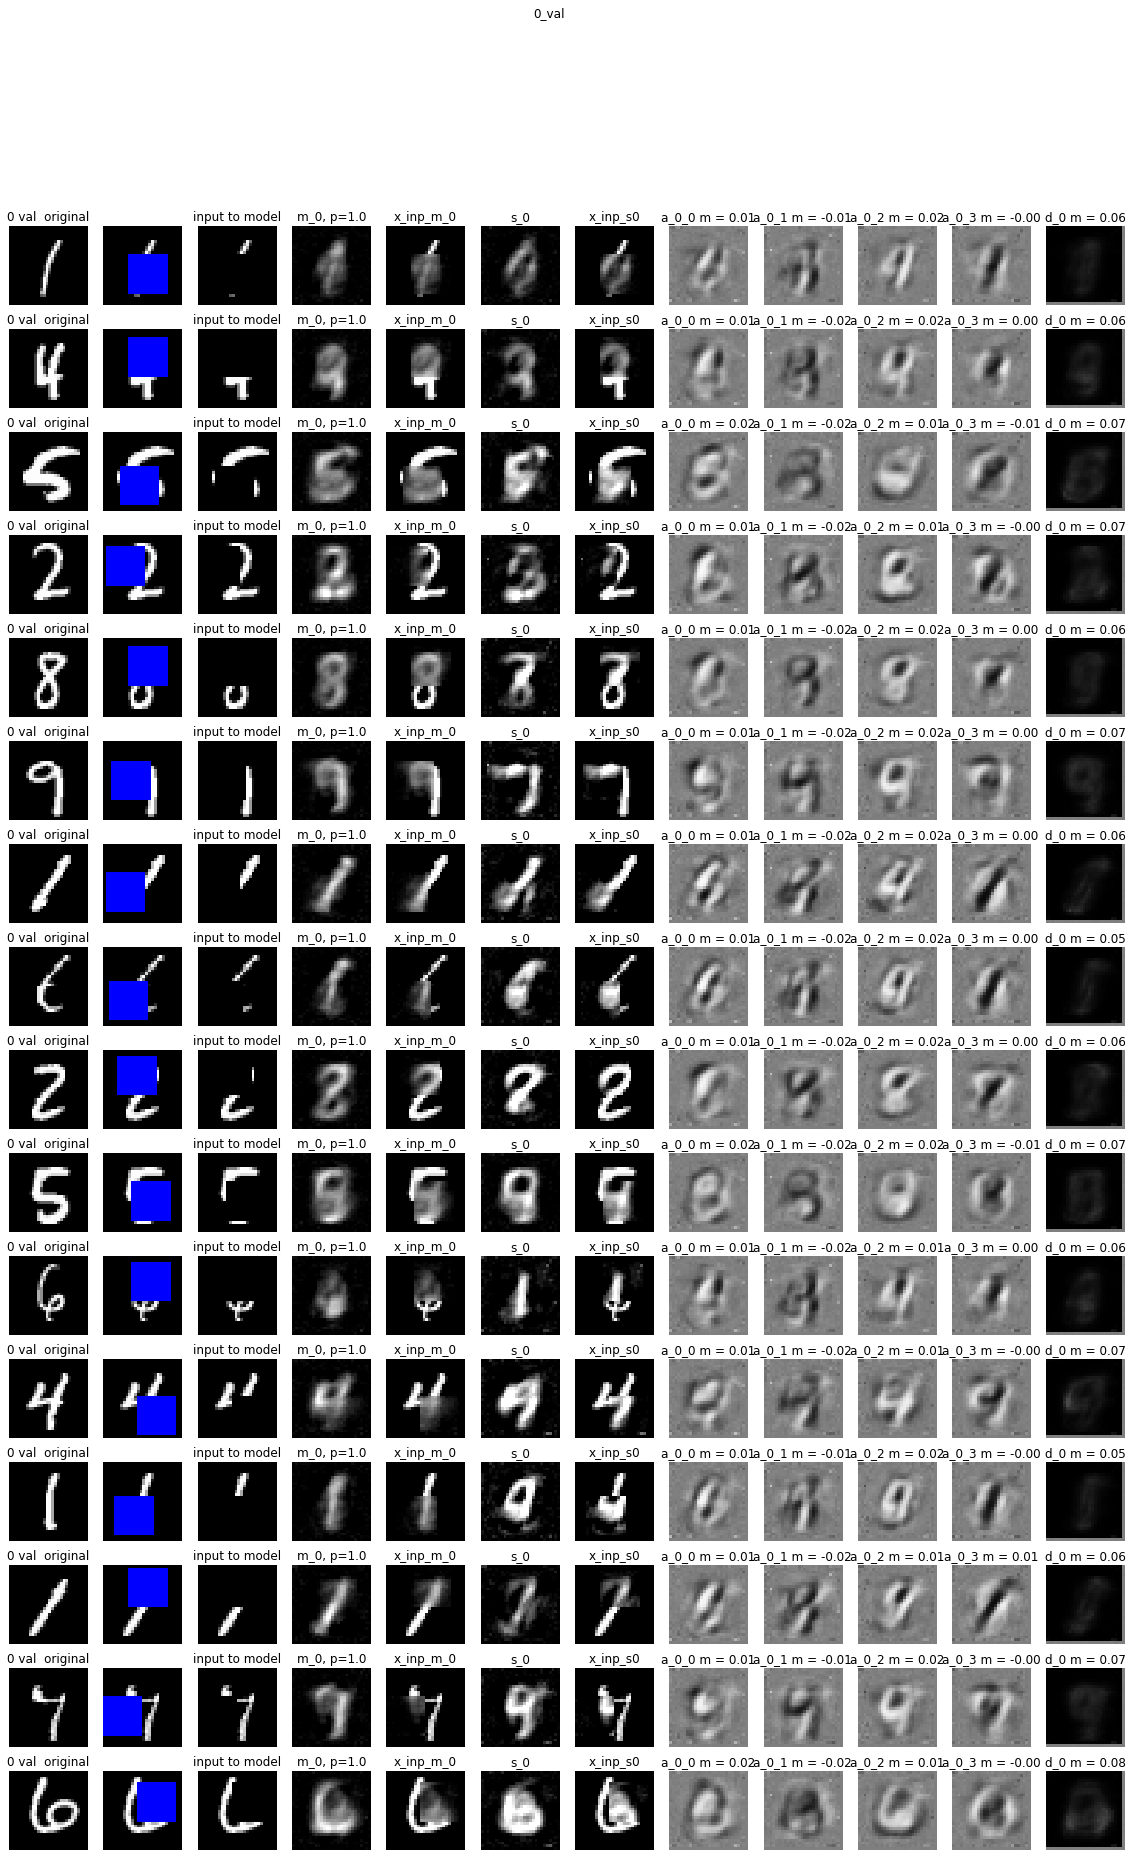

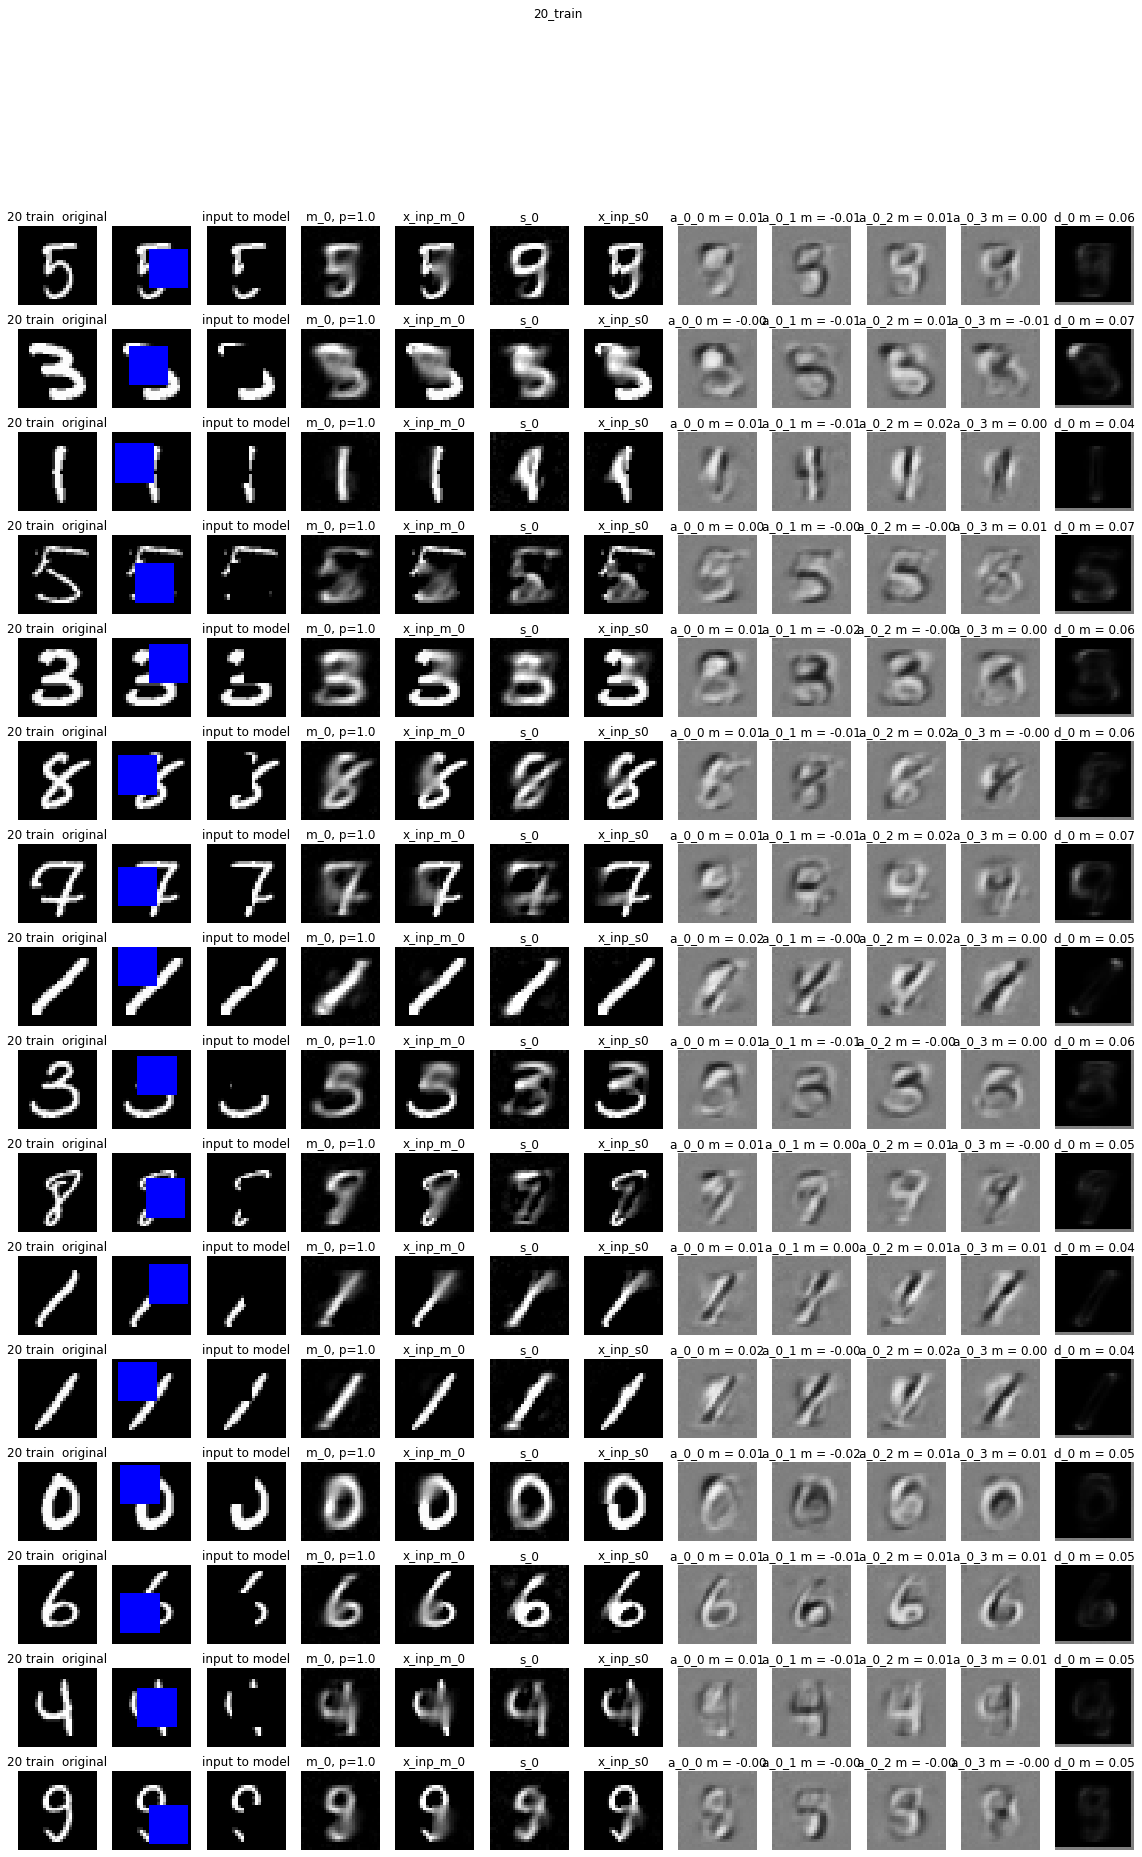

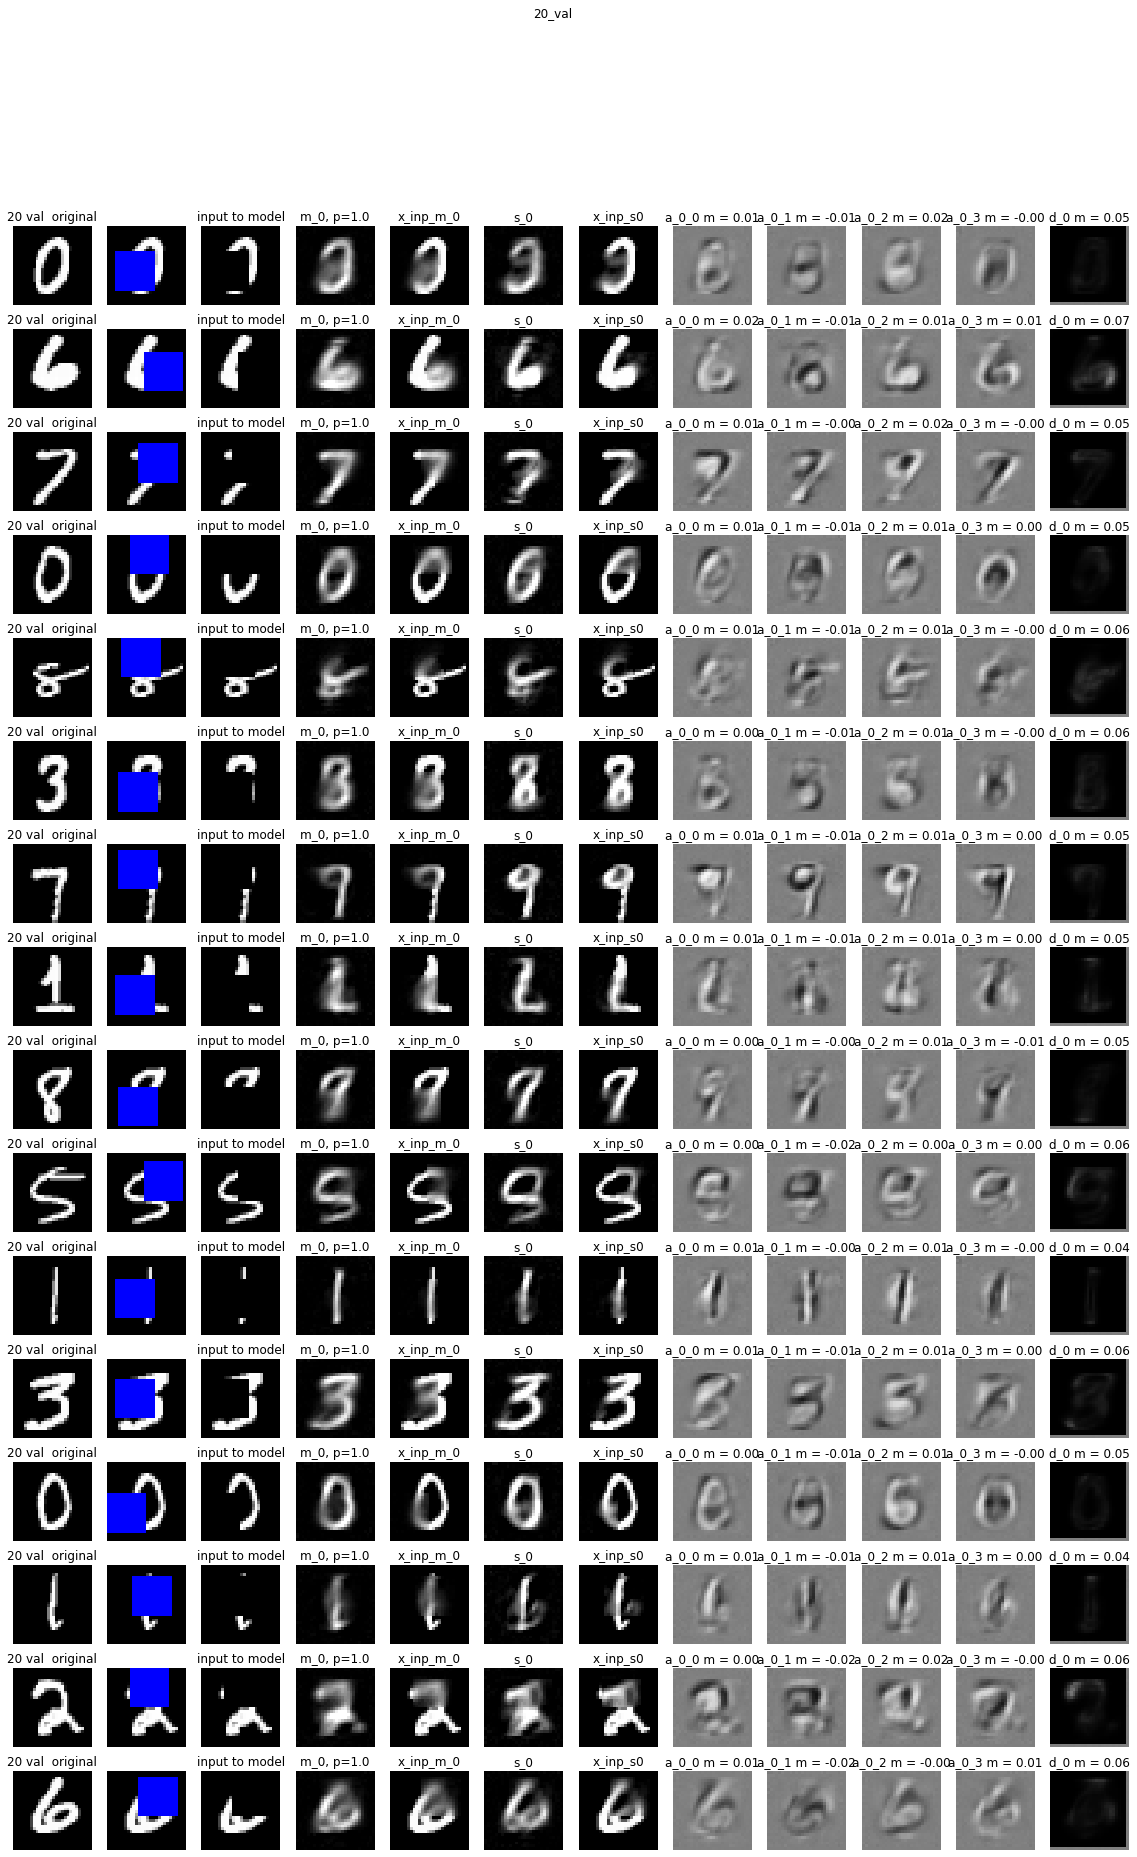

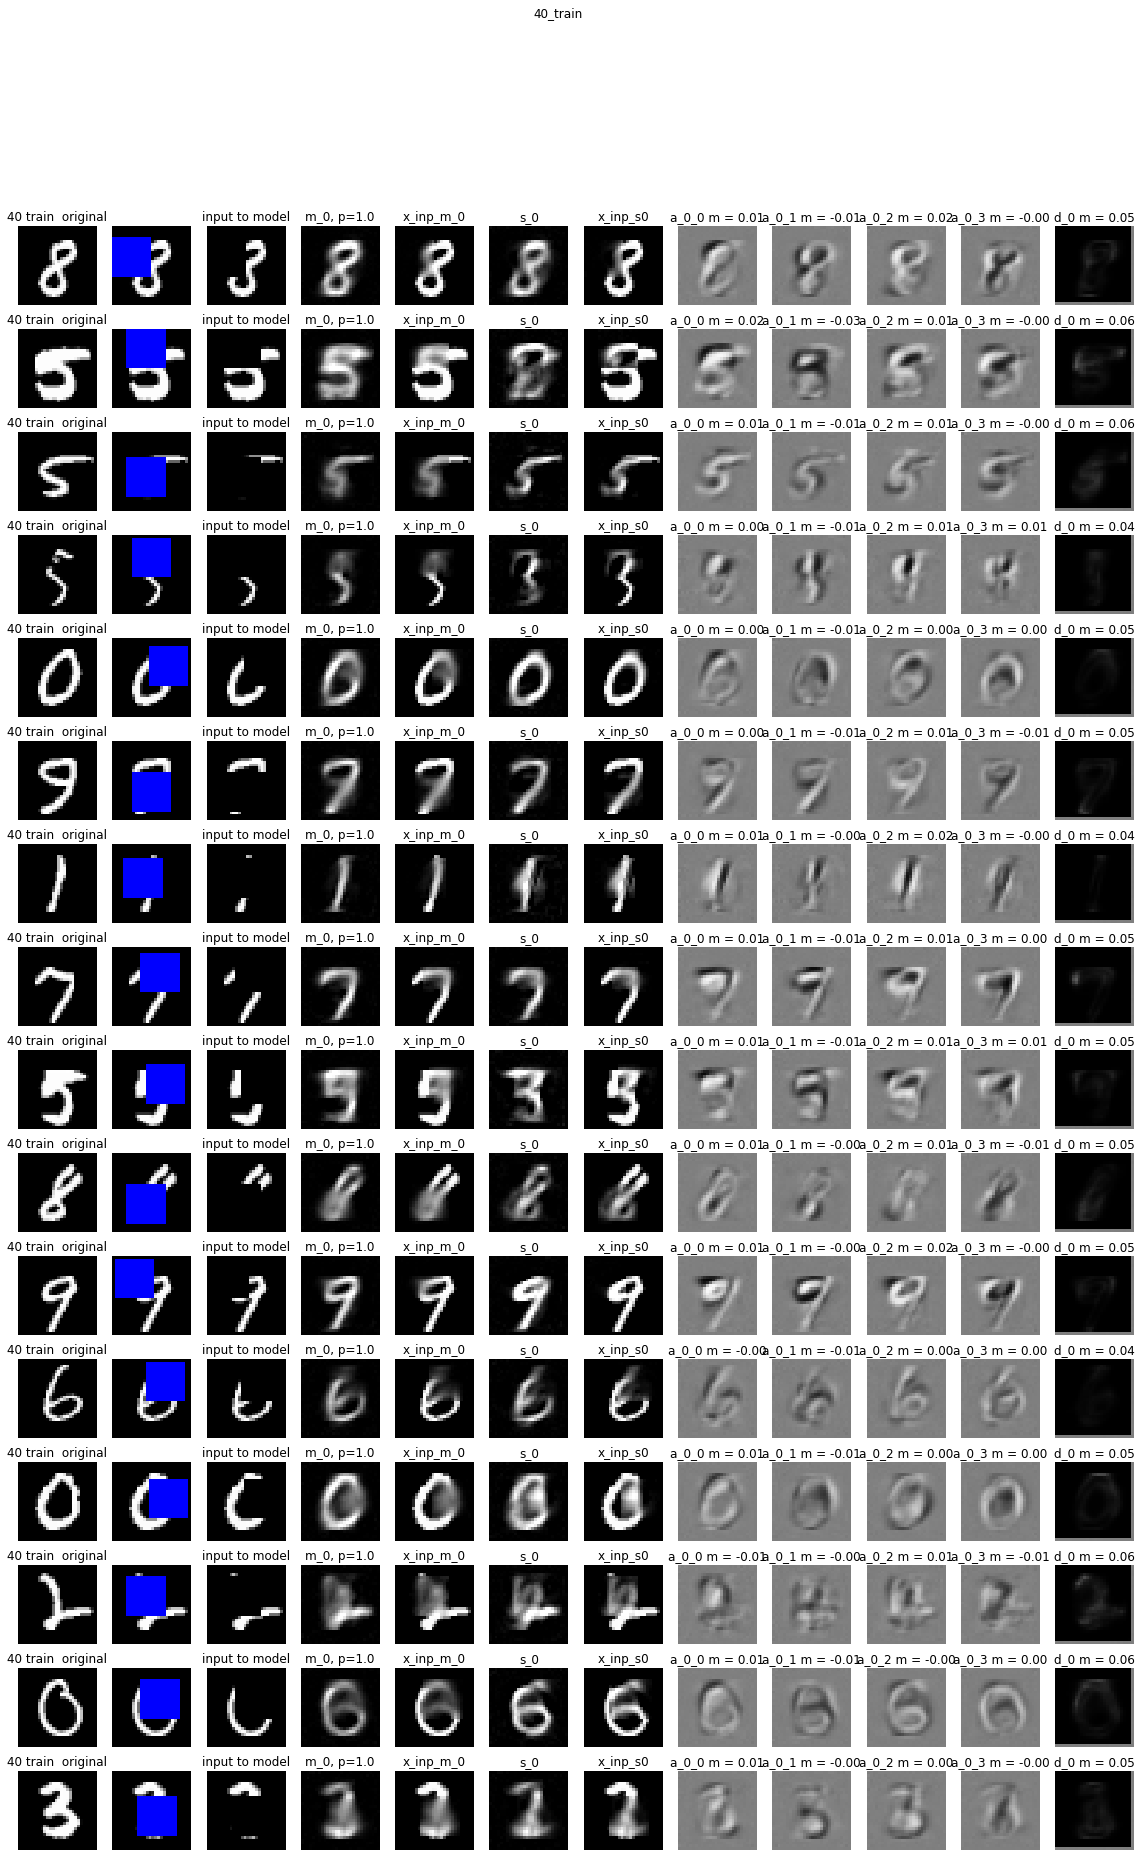

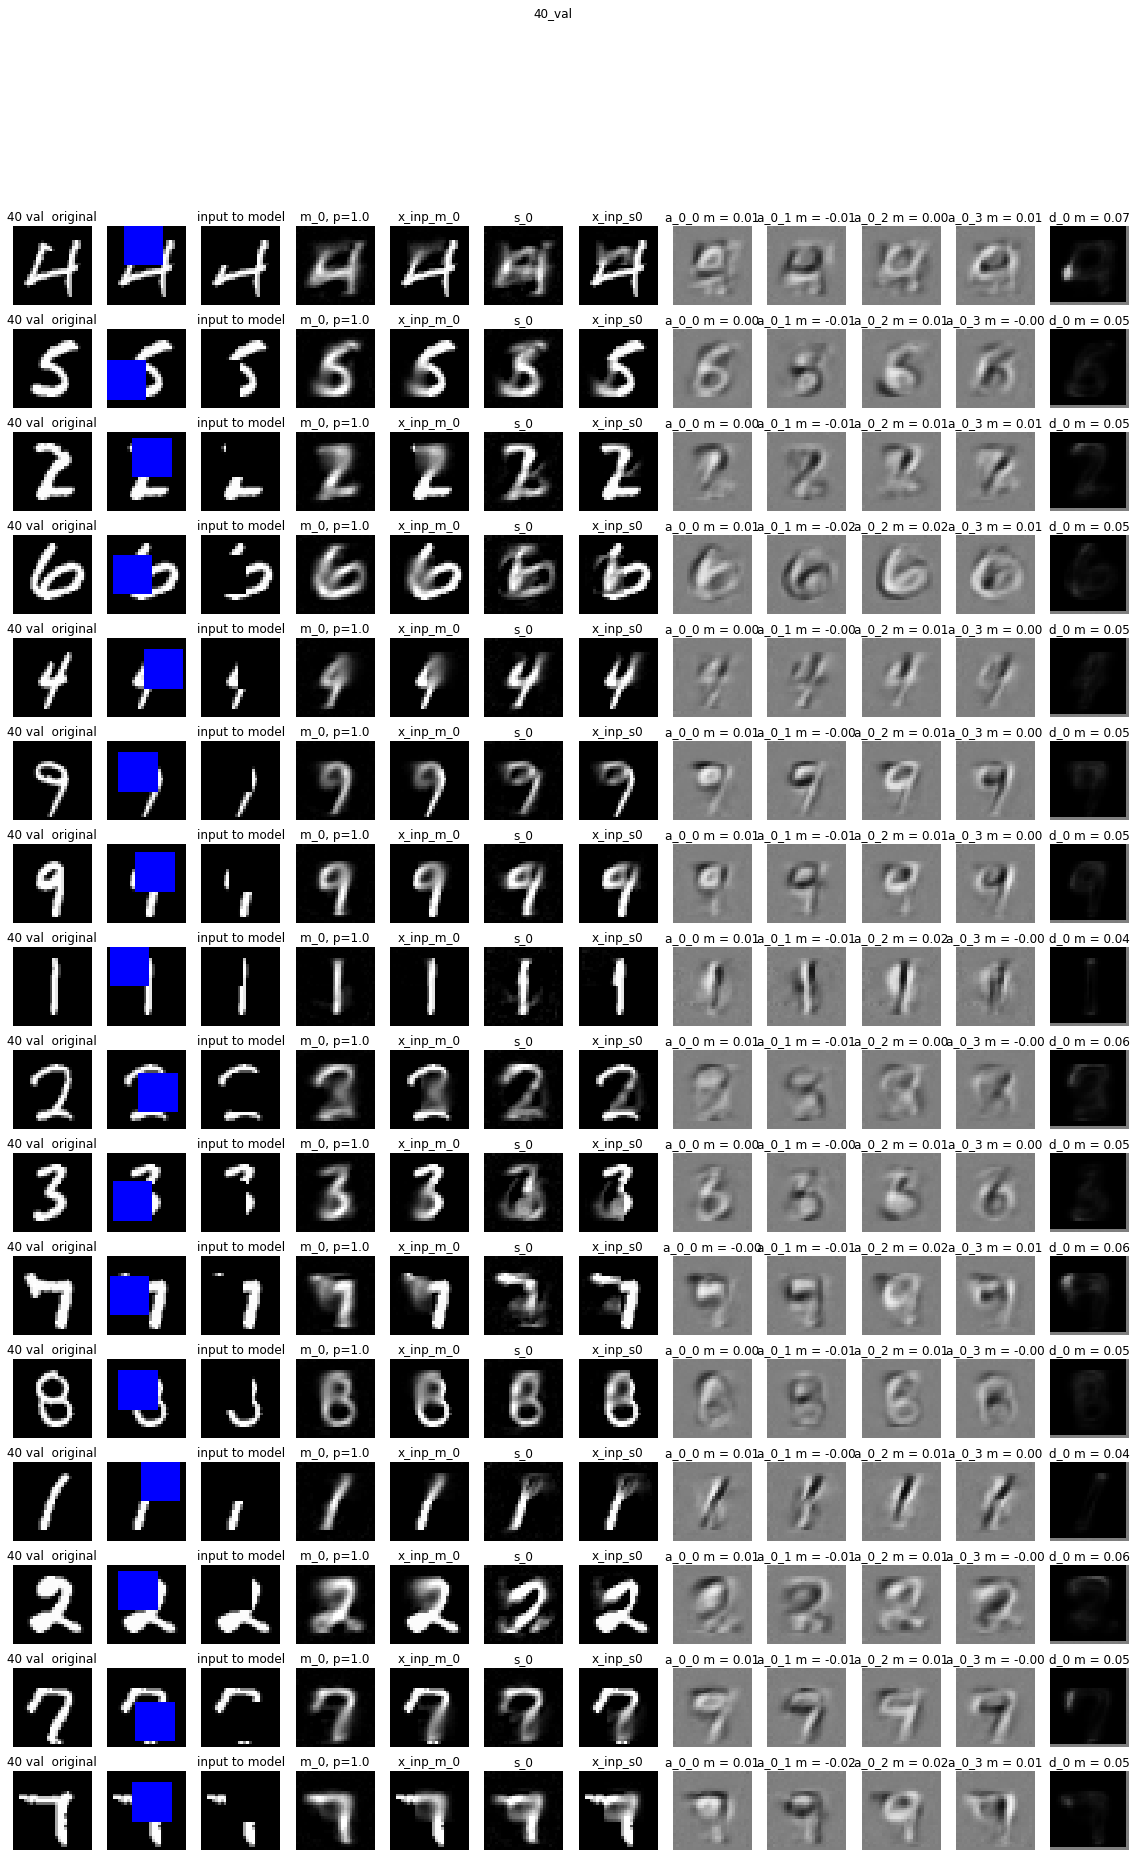

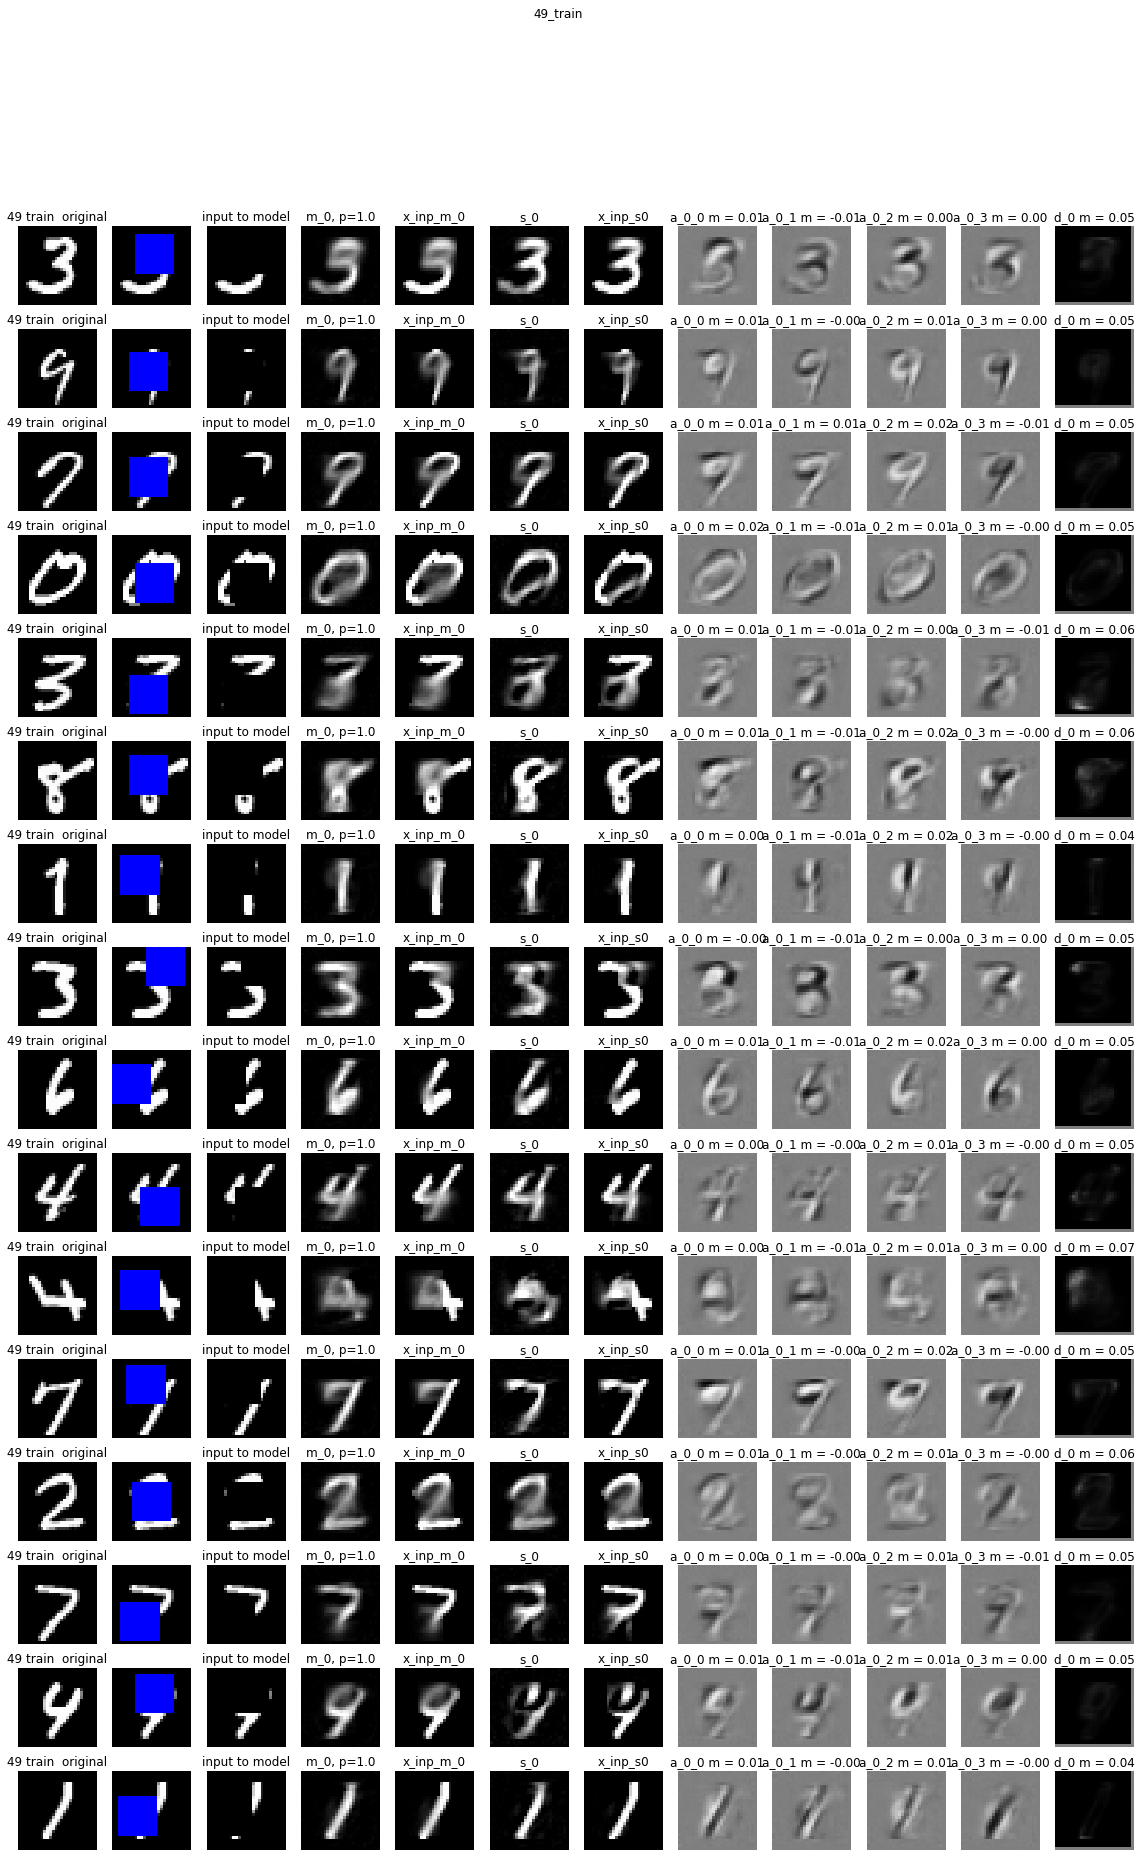

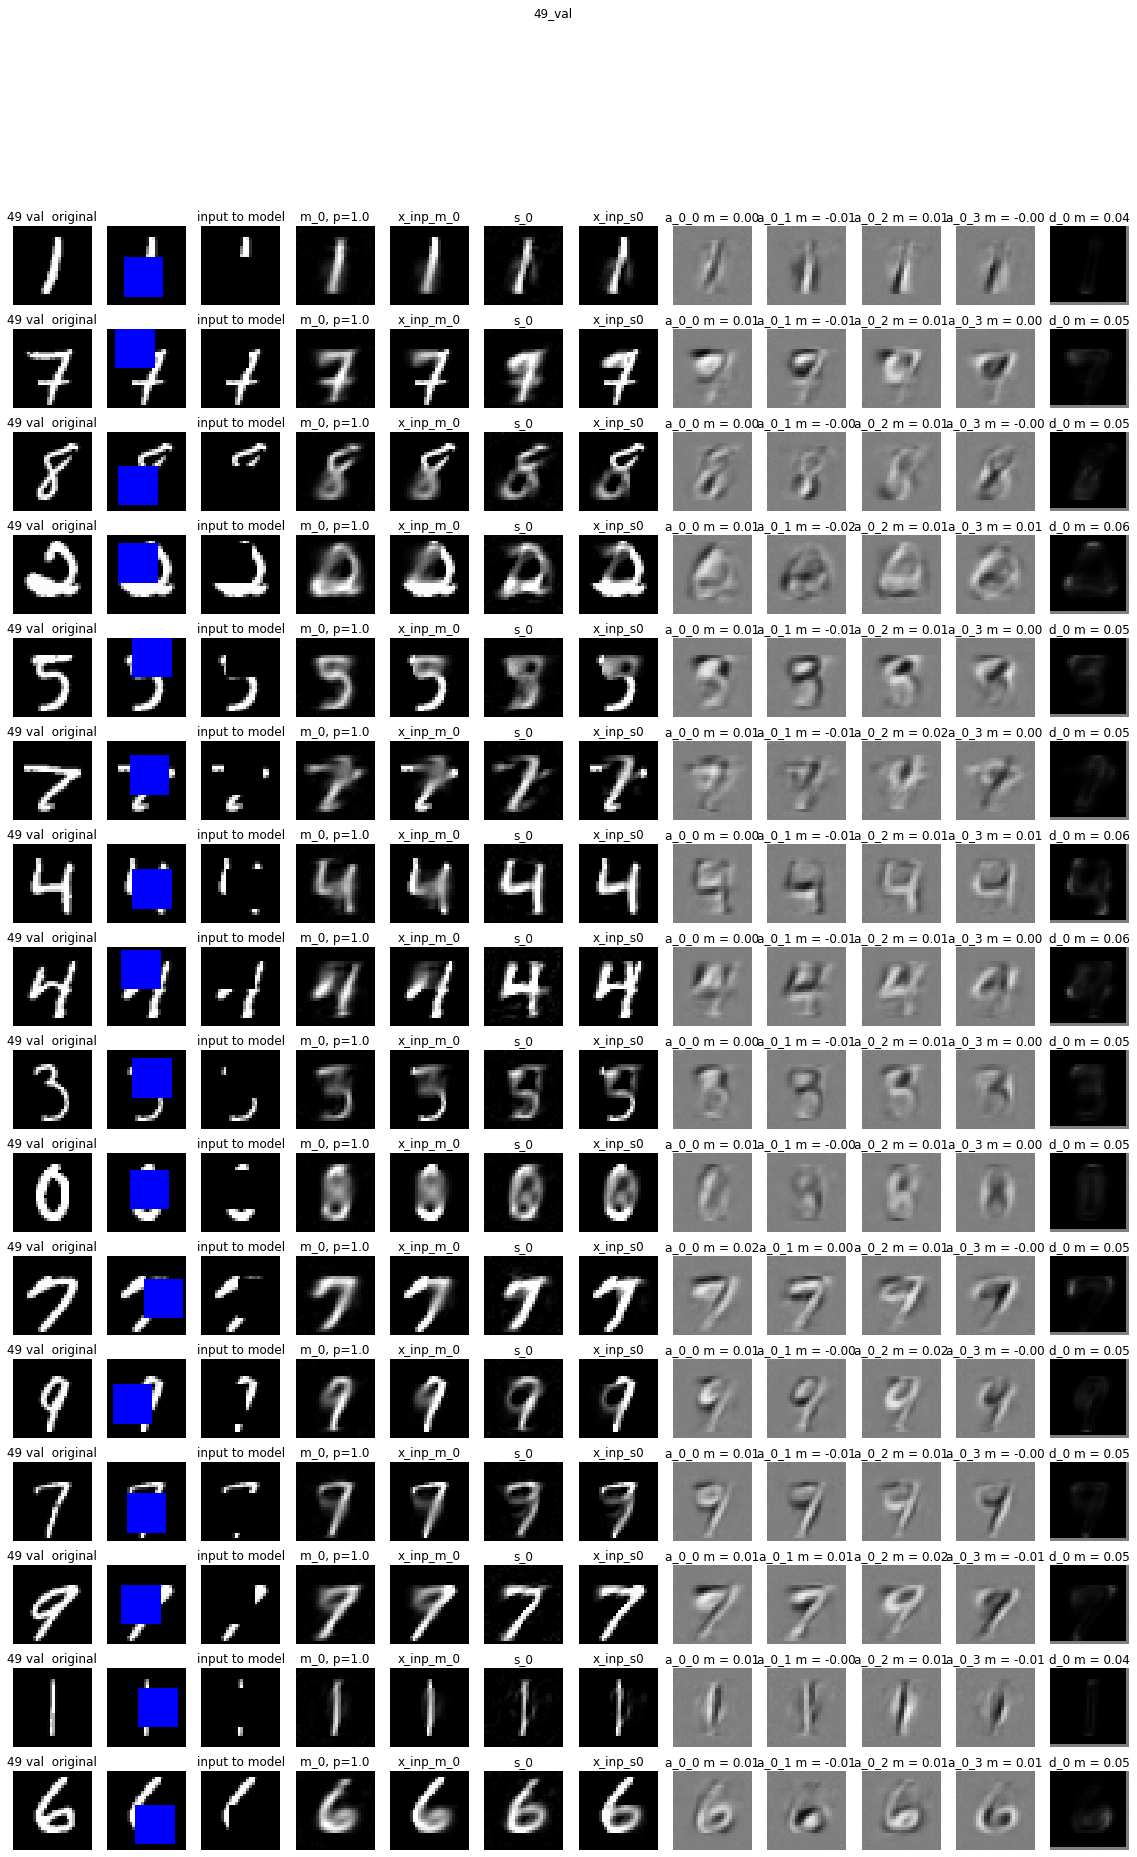

In [22]:
epochs_path = experiment_path / "epochs"
epochs_path.mkdir(exist_ok=True)
skip = 20
n_rows = 16

for e, h in enumerate(history):
    if e % skip !=0 and e != (len(history) -1):
        continue
    
    for ax_no, fold in [(0,"train"), (1,"val")]:
        
        
        row_length = vis.row_length(*list(zip(*h["sample_results"][fold]))[0])

        fig, axes = plt.subplots(
            n_rows, 
            row_length,
            figsize=(20, 30)
        )

        for row_no, (x, j, p, m ,a, d, y) in enumerate(list(zip(*h["sample_results"][fold]))[:n_rows]):
            vis.visualize_sample(
                x, j, p, m, a, d, y, 
                ax_row=axes[row_no], 
                title_prefixes={
                    0: f"{e} {fold} ",
#                     1: f"y_m = {y_masked_pred}"
                },
                drawing_fn=vis_digit_mask

            )
        
        title = f"{e}_{fold}"
        plt.suptitle(title)
        plt.savefig(epochs_path / f"{title}.png")
#       

In [23]:
import pickle

with (experiment_path / "history_last_epoch.pkl").open("rb") as f:
    hist_last_epoch = pickle.load(f)

history = [hist_last_epoch]

In [24]:
import matplotlib.pyplot as plt

def plot_arrays_stats(
    arrays, ax=None, stat_fns = [np.min, np.max, np.mean], markers="."
):
    if ax is None:
        fig, ax = plt.subplots()
        
    if isinstance(markers, str):
        markers = [markers] * len(stat_fns)
    
    for fn, m in zip(stat_fns, markers):
        ax.scatter(
            range(len(arrays)),
            [
                fn(a) for a in arrays
            ],
            marker=m,
            label=fn.__name__
            
        )
    
    return ax

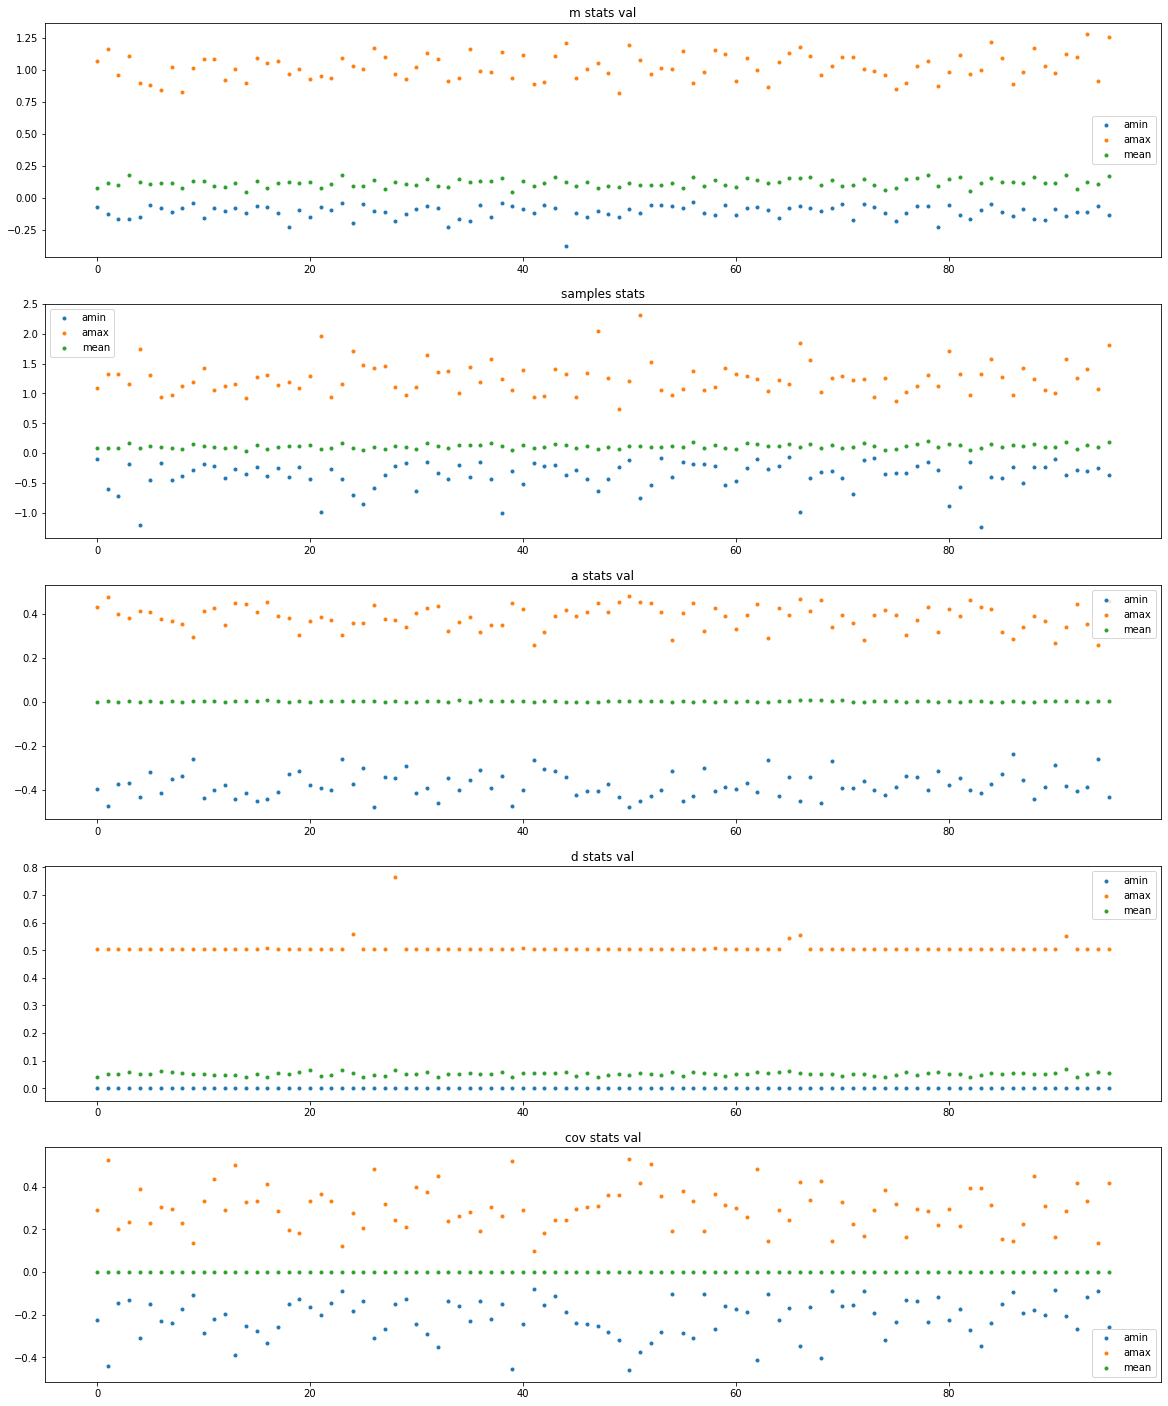

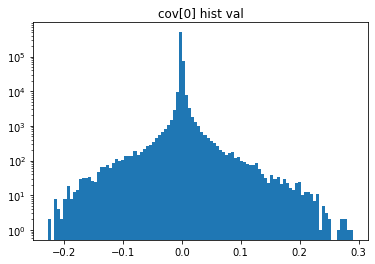

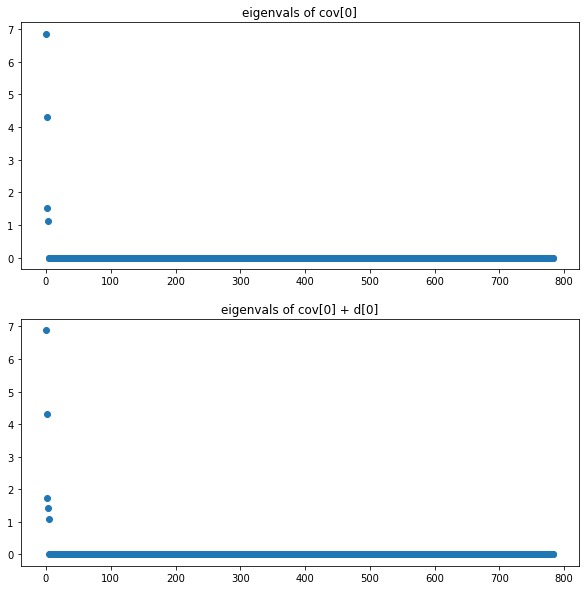

m analysis


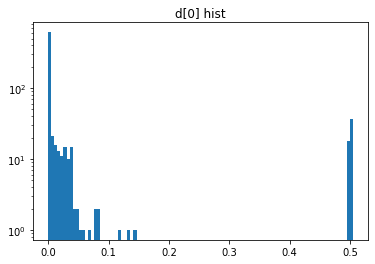

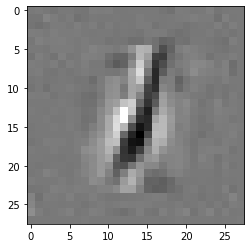

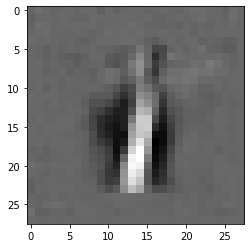

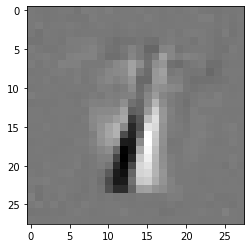

In [25]:
for fold in ["val"]:
    x, j, p, m, a, d, y = hist_last_epoch["sample_results"][fold]

    a_resh = a.reshape(a.shape[0] * a.shape[1], a.shape[2], a.shape[3])
    covs = a_resh.transpose(0, 2, 1) @ a_resh
    
    fig, ax = plt.subplots(figsize=(20, 25), nrows=5)
    
    ax[0].set_title(f"m stats {fold}")
    plot_arrays_stats(
        m, ax[0]
    )
        
    samples = [
        vis.gans_gmms_sample_no_d(x_, m_[0], a_[0], d_[0])
        for (x_, m_, a_, d_) in zip(x, m ,a, d)
    ]
    
    ax[1].set_title("samples stats")
    plot_arrays_stats(samples, ax[1])
    
    ax[2].set_title(f"a stats {fold}")
    plot_arrays_stats(
        a, ax[2]
    )
    
    ax[3].set_title(f"d stats {fold}")
    plot_arrays_stats(
        d, ax[3]
    )
    
    ax[4].set_title(f"cov stats {fold}")
    plot_arrays_stats(
        covs, ax[4]
    )
    [a.legend() for a in ax[:5]]
    fig.savefig(experiment_path / f"outputs_stats.png")
    plt.show()
    
    cov_resh = covs[0].reshape(-1)
    plt.hist(cov_resh, log=True, bins=100)
    plt.title(f"cov[0] hist {fold}")
    plt.show()
    
    cov = covs[0]
    
    fig, ax = plt.subplots(figsize=(10, 10), nrows=2)
    eigs = np.linalg.eigvals(cov)
    ax[0].scatter(range(len(eigs)), eigs)
    ax[0].set_title("eigenvals of cov[0]")

    cov_d = cov + np.diag(d[0])
    eigs_d = np.linalg.eigvals(cov_d)
    ax[1].scatter(range(len(eigs_d)), eigs_d)
    ax[1].set_title("eigenvals of cov[0] + d[0]")
    fig.savefig(experiment_path / "eigenvals.png")
    plt.show()

    # wygląda na to, że mamy ~3 duże wartosci własne
    
    print("m analysis")
    
    
    plt.hist(d[0].reshape(-1), bins=100, log=True)
    plt.title("d[0] hist")
    plt.show()
    
    for i in range(3):
        plt.imshow(a_resh[0, i].reshape(28,28), cmap="gray")
        plt.show()
    
    
    
    

In [26]:
# next up
# * różne aktywacje wyjścia macierzy A (sigmoid? różne zakresy?)
# * wyplotować wielkość wartości własne A, D na przestrzeni treningu
# spróbować trenowania na niepełnych danych

MNISTConvolutionalInpainter(
  (extractor): Sequential(
    (0): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Reshape(out_size=(-1, 100352))
  )
  (a_extractor): Sequential(
    (0): Linear(in_features=100352, out_features=3136, bias=True)
    (1): Reshape(out_size=(-1, 1, 4, 784))
    (2): LambdaLayer()
  )
  (m_extractor): Sequential(
    (0): Linear(in_features=100352, out_features=784, bias=True)
    (1): Reshape(out_size=(-1, 1, 784))
  )
  (d_extractor): Sequential(
    (0): Linear(in_features=100352, out_features=784, bias=True)
    (1): Reshape(out_size=(-1, 1, 784))
    (2): LambdaLayer()
  )
  (p_extractor): Sequential(
    (0): Linear(in_features=100352, out_fea

In [41]:
val_results = predictions_for_entire_loader(
    inpainter.to(torch.device("cpu")),
    dl_val,
    torch.device("cpu")
    
)


0it [00:00, ?it/s]
1it [00:02,  2.53s/it]
2it [00:05,  2.55s/it]
3it [00:07,  2.54s/it]
4it [00:10,  2.53s/it]
5it [00:12,  2.53s/it]
6it [00:15,  2.63s/it]
7it [00:18,  2.63s/it]
8it [00:21,  2.73s/it]
9it [00:23,  2.63s/it]
10it [00:26,  2.59s/it]
11it [00:29,  2.71s/it]
12it [00:31,  2.68s/it]
13it [00:34,  2.60s/it]
14it [00:36,  2.53s/it]
15it [00:38,  2.47s/it]
16it [00:41,  2.51s/it]
17it [00:43,  2.52s/it]
18it [00:46,  2.50s/it]
19it [00:48,  2.44s/it]
20it [00:50,  2.37s/it]
21it [00:53,  2.39s/it]
22it [00:55,  2.41s/it]
23it [00:58,  2.43s/it]
24it [01:00,  2.53s/it]
25it [01:03,  2.64s/it]
26it [01:06,  2.68s/it]
27it [01:09,  2.68s/it]
28it [01:12,  2.73s/it]
29it [01:14,  2.61s/it]
30it [01:16,  2.53s/it]
31it [01:19,  2.60s/it]
32it [01:22,  2.69s/it]
33it [01:24,  2.58s/it]
34it [01:27,  2.60s/it]
35it [01:30,  2.63s/it]
36it [01:33,  2.70s/it]
37it [01:35,  2.63s/it]
38it [01:38,  2.59s/it]
39it [01:40,  2.68s/it]
40it [01:43,  2.60s/it]
41it [01:45,  2.56s/it]
42it 

In [38]:
with (experiment_path / "val_predictions.pkl").open("wb") as f:
    pickle.dump(val_results, f)
    

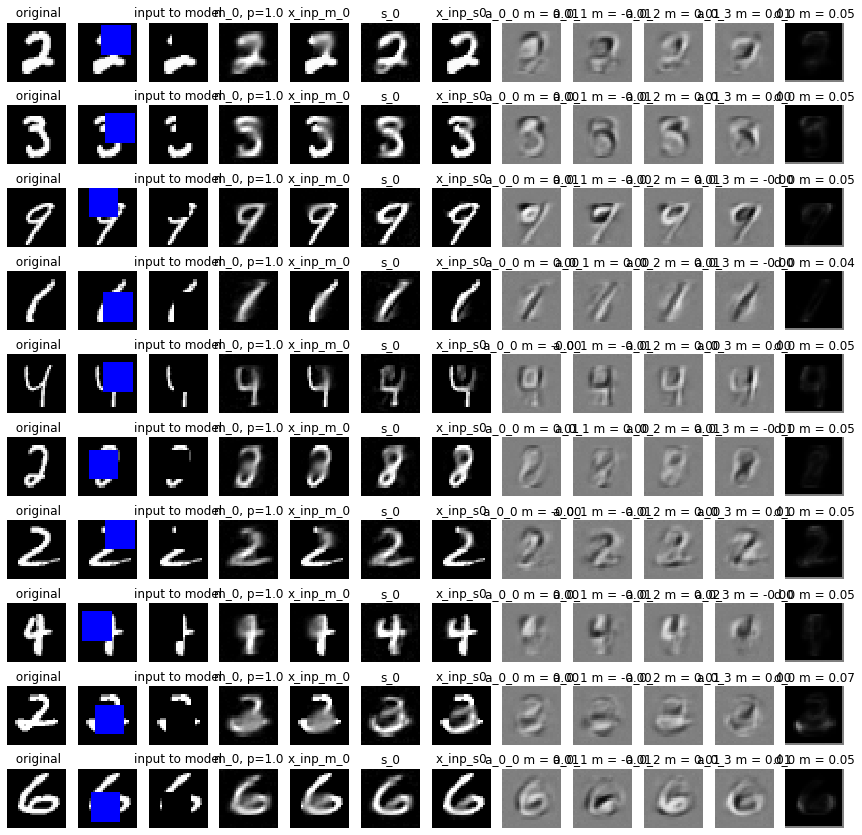

In [42]:
fig, ax = plt.subplots(10, 12, figsize=(15,15)
)

for i in range(10):
    vis.visualize_sample(
        *val_results[i],
        drawing_fn=vis_digit_mask,
        title_prefixes=dict(),
        ax_row=ax[i]
    )